In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.simplefilter(action='ignore')


In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [4]:
print(df['HeartDisease'].value_counts())

HeartDisease
1    508
0    410
Name: count, dtype: int64


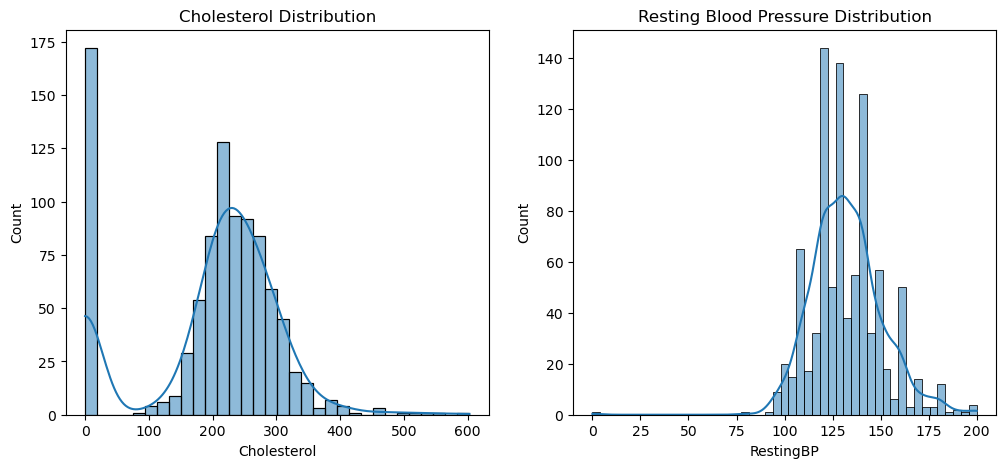

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Cholesterol'], kde=True)
plt.title('Cholesterol Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['RestingBP'], kde=True)
plt.title('Resting Blood Pressure Distribution')
plt.show()

In [6]:
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']


Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Remaining samples after outlier removal:", df.shape[0])


Remaining samples after outlier removal: 588


In [7]:
# Cell 5: Feature Engineering

# Create new features that might be beneficial for prediction:
# 1. Cholesterol_Age_Ratio: The ratio of cholesterol level to age
df['Cholesterol_Age_Ratio'] = df['Cholesterol'] / df['Age']

# 2. BP_Cholesterol_Ratio: The ratio of resting blood pressure to cholesterol
df['BP_Cholesterol_Ratio'] = df['RestingBP'] / (df['Cholesterol'] + 1)  # add 1 to avoid division by zero

# 3. Heart_Rate_to_Age: A relation between MaxHR and Age
df['Heart_Rate_to_Age'] = df['MaxHR'] / df['Age']

# Check new columns
df.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Cholesterol_Age_Ratio,BP_Cholesterol_Ratio,Heart_Rate_to_Age
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,7.225000,0.482759,4.300000
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,3.673469,0.883978,3.183673
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,7.648649,0.457746,2.648649
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,4.458333,0.641860,2.250000
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,3.611111,0.765306,2.259259


In [8]:
#Categorical Encoding
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [9]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [10]:
scaler = StandardScaler()
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 
            'Cholesterol_Age_Ratio', 'BP_Cholesterol_Ratio', 'Heart_Rate_to_Age']
X[num_cols] = scaler.fit_transform(X[num_cols])


In [11]:
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 470
Test set size: 118


In [12]:
#Train models and evaluate 

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    #Print model performance
    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")


=== Logistic Regression ===
Accuracy: 0.8898305084745762
Confusion Matrix:
 [[65  3]
 [10 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91        68
           1       0.93      0.80      0.86        50

    accuracy                           0.89       118
   macro avg       0.90      0.88      0.88       118
weighted avg       0.89      0.89      0.89       118



=== Random Forest ===
Accuracy: 0.9067796610169492
Confusion Matrix:
 [[63  5]
 [ 6 44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92        68
           1       0.90      0.88      0.89        50

    accuracy                           0.91       118
   macro avg       0.91      0.90      0.90       118
weighted avg       0.91      0.91      0.91       118



=== XGBoost ===
Accuracy: 0.8898305084745762
Confusion Matrix:
 [[64  4]
 [ 9 41]]
Classification Report:
    

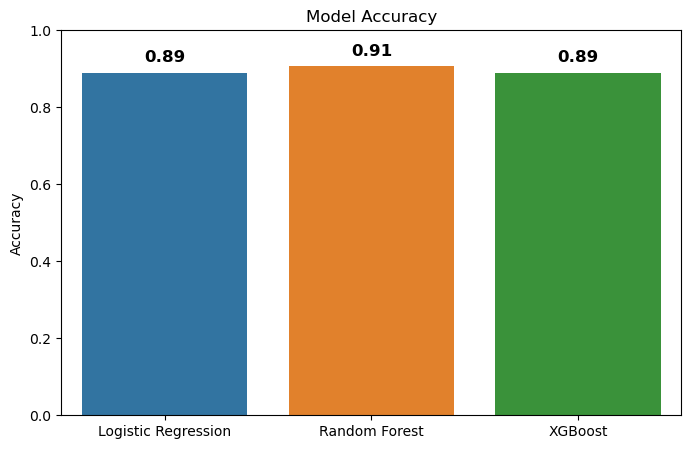

In [19]:

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.ylim(0, 1)
for i, (model, acc) in enumerate(results.items()):
    ax.text(i, acc + 0.02, f"{acc:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.show()


In [20]:
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)
final_pred = best_model.predict(X_test)

print("Final Accuracy (RandomForest):", accuracy_score(y_test, final_pred))


Final Accuracy (RandomForest): 0.9067796610169492


In [15]:
# # Cell 8: (Optional) Save the preprocessed data for further modeling
# X_train.to_csv("X_train_preprocessed.csv", index=False)
# X_test.to_csv("X_test_preprocessed.csv", index=False)
# y_train.to_csv("y_train_preprocessed.csv", index=False)
# y_test.to_csv("y_test_preprocessed.csv", index=False)

# print("Preprocessed datasets saved to disk.")